In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import tensorflow as tf
import numpy as np
# from tensorflow_model_optimization.python.core.keras.compat import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import random
tf.random.set_seed(3407)
np.random.seed(3407)
random.seed(3407)

from create_spectrogram import (
    create_spectrograms_from_audio_dataset, 
)
from helper_functions import (
    get_file_size, 
    convert_bytes, 
    convert_prefetchdataset_to_numpy_arrays,
    predict_and_print_full_results,
    evaluate_time_of_prediction
    )

In [31]:
sample_rate = 16000

In [32]:
train_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/training", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
test_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/testing", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
val_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/validation", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)

label_names = np.array(train_dataset.class_names)
print("Classes: ", label_names)

Found 11292 files belonging to 2 classes.
Found 1393 files belonging to 2 classes.
Found 1380 files belonging to 2 classes.
Classes:  ['non_target' 'target']


In [33]:
train_spectrogram_ds = create_spectrograms_from_audio_dataset(train_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = create_spectrograms_from_audio_dataset(test_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = create_spectrograms_from_audio_dataset(val_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)

x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds)
x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)
x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_spectrogram_ds)

tf.Tensor([0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0], shape=(32,), dtype=int32)
0
tf.Tensor([0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
0
tf.Tensor([1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0], shape=(32,), dtype=int32)
1


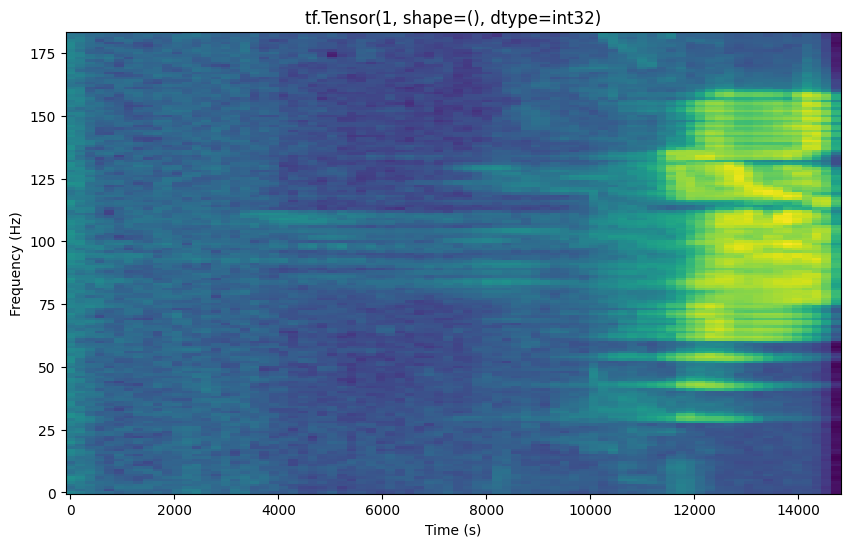

In [34]:
# non-target = 0, target = 1
# Print spectrograms of target or non-target class from dataset
class_number = 1

for i in train_spectrogram_ds:
    print(i[1])
    print(i[1][0].numpy())
    if i[1][0].numpy() == class_number:
        spectrogram = i[0][0]
        height = spectrogram.shape[0]
        width = spectrogram.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(X, Y, spectrogram)
        plt.title(i[1][0])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
        break

In [8]:
num_labels = len(label_names)
print('Number of classes:', num_labels)

model = keras.Sequential([
    keras.layers.Input(shape=(184, 80, 1)),
    keras.layers.Conv2D(4, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(4, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Reshape((44*18*4, )),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(num_labels),
])

model.summary()



Number of classes: 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 182, 78, 4)        40        
                                                                 
 max_pooling2d (MaxPooling2  (None, 91, 39, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 37, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 18, 4)         0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 3168)              0         
                                                                 
 dense (Dense)               (None,

In [9]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# EPOCHS = 1
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/15
353/353 [==============================] - 12s 32ms/step - loss: 0.2314 - accuracy: 0.9052
Epoch 2/15
353/353 [==============================] - 10s 29ms/step - loss: 0.1136 - accuracy: 0.9554
Epoch 3/15
353/353 [==============================] - 10s 28ms/step - loss: 0.0740 - accuracy: 0.9717
Epoch 4/15
353/353 [==============================] - 10s 28ms/step - loss: 0.0566 - accuracy: 0.9796
Epoch 5/15
353/353 [==============================] - 10s 28ms/step - loss: 0.0418 - accuracy: 0.9865
Epoch 6/15
353/353 [==============================] - 10s 28ms/step - loss: 0.0375 - accuracy: 0.9870
Epoch 7/15
353/353 [==============================] - 10s 29ms/step - loss: 0.0283 - accuracy: 0.9902
Epoch 8/15
353/353 [==============================] - 11s 30ms/step - loss: 0.0225 - accuracy: 0.9918
Epoch 9/15
353/353 [==============================] - 10s 30ms/step - loss: 0.0184 - accuracy: 0.9934
Epoch 10/15
353/353 [==============================] - 9s 27ms/step - loss: 0.0189

In [14]:
print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model, x_test_np, y_test_np, model_format="keras")


Validation dataset:
44/44 [==============================] - 1s 11ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 99.06%
Recall: 99.36%
Precision: 97.91%
F1-score: 98.63%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.986689172446992

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9862847232085902

Test dataset:
44/44 [==============================] - 0s 10ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.99%
Recall: 99.13%
Precision: 97.84%
F1-score: 98.48%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9844262846996378

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9840657834049555


In [15]:
print("For Test dataset:")
evaluate_time_of_prediction(model, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


For Test dataset:
Accuracy: 98.99%
Recall: 99.13%
Precision: 97.84%
F1-score: 98.48%

Time to make a prediction for a single data point
Mean: 0.052 seconds
Max: 0.275 seconds
Min: 0.041 seconds


In [16]:
BASE_MODEL_FILE_NAME = "spectrogram_models_from_notebooks/cnn/cnn_mel_spec_16kHz_baseline.keras"
# model.save(BASE_MODEL_FILE_NAME)
# print("Model file name: ", BASE_MODEL_FILE_NAME)
# convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

In [17]:
model_loaded = tf.keras.models.load_model(BASE_MODEL_FILE_NAME)

In [18]:
print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_loaded, x_test_np, y_test_np, model_format="keras")



Test dataset:
44/44 [==============================] - 1s 12ms/step
Basic assessment of the whole dataset (without any partitions):
Accuracy: 98.99%
Recall: 99.13%
Precision: 97.84%
F1-score: 98.48%

Devide dataset into 10 non-overlapping patritions and get their mean F1-score
Non-overlap mean F1-score:  0.9844262846996378

Get 100 bootstrap samples from dataset with 100 samples each and get their mean F1-score
Bootstrap mean F1-score:  0.9843090217523874


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 182, 78, 4)        40        
                                                                 
 max_pooling2d (MaxPooling2  (None, 91, 39, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 37, 4)         148       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 18, 4)         0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 3168)              0         
                                                                 
 dense (Dense)               (None, 8)                 2

In [20]:
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "KB")

File size: 335.824 Kilobytes
